In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [53]:
df_clean = pd.read_csv("cleaned_traffic_crashes.csv")
df_clean.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,...,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,location
0,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,22,4,1,POINT (-87.551093105845 41.713829100033)
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.755202215729 41.796710893317)
2,30,OTHER,OTHER,OTHER,UNKNOWN,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,OTHER,UNKNOWN,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.603822899265 41.813004951227)
3,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,3.0,0.0,22,4,1,POINT (-87.705668192505 41.868335288795)
4,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.696128029764 41.866617682133)


In [54]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024029 entries, 0 to 1024028
Data columns (total 33 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   posted_speed_limit             1024029 non-null  int64  
 1   traffic_control_device         1024029 non-null  object 
 2   device_condition               1024029 non-null  object 
 3   weather_condition              1024029 non-null  object 
 4   lighting_condition             1024029 non-null  object 
 5   first_crash_type               1024029 non-null  object 
 6   trafficway_type                1024029 non-null  object 
 7   alignment                      1024029 non-null  object 
 8   roadway_surface_cond           1024029 non-null  object 
 9   road_defect                    1024029 non-null  object 
 10  report_type                    1024029 non-null  object 
 11  crash_type                     1024029 non-null  object 
 12  damage        

In [55]:
df_clean.isnull().sum()

posted_speed_limit               0
traffic_control_device           0
device_condition                 0
weather_condition                0
lighting_condition               0
first_crash_type                 0
trafficway_type                  0
alignment                        0
roadway_surface_cond             0
road_defect                      0
report_type                      0
crash_type                       0
damage                           0
date_police_notified             0
prim_contributory_cause          0
sec_contributory_cause           0
street_no                        0
street_direction                 0
street_name                      0
beat_of_occurrence               0
num_units                        0
most_severe_injury               0
injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_no_indication           0
injuries_unknown    

In [56]:
df_clean.duplicated().value_counts()

False    1023967
True          62
dtype: int64

In [57]:
df_clean = df_clean.drop_duplicates()
df_clean.duplicated().value_counts()

False    1023967
dtype: int64

In [ ]:
columns_to_drop = ['date_police_notified', 'street_name', 'location', 'sec_contributory_cause', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown']
df_clean = df_clean.drop(columns=columns_to_drop)

In [58]:
df_clean['prim_contributory_cause']

0                    UNABLE TO DETERMINE
1                    UNABLE TO DETERMINE
2                    UNABLE TO DETERMINE
3            IMPROPER OVERTAKING/PASSING
4                    IMPROPER LANE USAGE
                       ...              
1024024              UNABLE TO DETERMINE
1024025    FAILING TO YIELD RIGHT-OF-WAY
1024026              UNABLE TO DETERMINE
1024027              UNABLE TO DETERMINE
1024028              IMPROPER LANE USAGE
Name: prim_contributory_cause, Length: 1023967, dtype: object

In [59]:
# Create a mapping dictionary
# This reduces 40 specific causes into 5 broad "Buckets"
cause_mapping = {
    # DRIVER ERROR (The biggest category)
    'FOLLOWING TOO CLOSELY': 'Driver Error',
    'FAILING TO YIELD RIGHT-OF-WAY': 'Driver Error',
    'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Driver Error',
    'IMPROPER BACKING': 'Driver Error',
    'IMPROPER OVERTAKING/PASSING': 'Driver Error',
    'IMPROPER TURNING/NO SIGNAL': 'Driver Error',
    'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Driver Error',
    'DISREGARDING TRAFFIC SIGNALS': 'Driver Error',
    'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Driver Error',
    'TEXTING': 'Driver Error',
    'DISTRACTION - FROM INSIDE VEHICLE': 'Driver Error',
    'DISTRACTION - FROM OUTSIDE VEHICLE': 'Driver Error',
    'PHYSICAL CONDITION OF DRIVER': 'Driver Error',
    
    # EXTERNAL FACTORS
    'WEATHER': 'External Factors',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'External Factors',
    'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'External Factors',
    'ANIMAL': 'External Factors',
    
    # VEHICLE DEFECTS
    'EQUIPMENT - VEHICLE CONDITION': 'Vehicle Defect',
    'BRAKESLESS/FAILURE': 'Vehicle Defect',
    
    # UNKNOWN (Usually the biggest or second biggest)
    'UNABLE TO DETERMINE': 'Unknown',
    'NOT APPLICABLE': 'Unknown'
}

# 1. Apply the mapping
# If a cause is NOT in the dictionary, we default it to 'Other'
df_clean['Crash_Cause'] = df_clean['prim_contributory_cause'].map(cause_mapping).fillna('Other')

#2.
# Drop original 
df_clean = df_clean.drop(columns=['prim_contributory_cause'])

# 3. Check the new counts
print(df_clean['Crash_Cause'].value_counts())

Driver Error        464460
Unknown             456025
Other                72879
External Factors     24352
Vehicle Defect        6251
Name: Crash_Cause, dtype: int64


In [72]:
df_clean.columns

Index(['posted_speed_limit', 'traffic_control_device', 'device_condition',
       'weather_condition', 'lighting_condition', 'first_crash_type',
       'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect',
       'report_type', 'crash_type', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'location', 'Crash_Cause'],
      dtype='object')

In [60]:
#Define X and Y
X = df_clean.drop(['Crash_Cause'], axis=1)
y = df_clean['Crash_Cause']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((767975, 32), (255992, 32))

In [62]:
X_train.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,...,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,location
542933,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,16,4,2,POINT (-87.667675892325 41.767398344981)
229323,20,NO CONTROLS,NO CONTROLS,UNKNOWN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,2,2,1,POINT (-87.710662647517 41.685042499437)
1003355,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,WET,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,9,5,4,POINT (-87.627992584751 41.764424393584)
78871,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,3.0,0.0,18,5,5,POINT (-87.65780618897 41.970484002516)
135407,35,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,22,4,10,POINT (-87.691311820716 41.928959464606)


In [63]:
X_test.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,...,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,location
247636,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,...,0.0,0.0,0.0,0.0,1.0,0.0,22,2,10,POINT (-87.72480502457 41.858758113772)
89763,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,...,0.0,0.0,0.0,0.0,2.0,0.0,14,5,4,POINT (-87.62757349122 41.879901430753)
887569,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,...,0.0,0.0,1.0,0.0,1.0,0.0,15,4,12,POINT (-87.664413101908 41.721064073751)
353486,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,15,3,11,POINT (-87.644136649796 41.794429853291)
225239,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,13,4,1,POINT (-87.799062546457 41.792097594278)


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

from sklearn.inspection import permutation_importance

In [65]:
# Group rare categories → much fewer one-hot columns
rare_threshold = 200   # adjust if needed (higher = fewer columns)

for col in ['street_name', 'first_crash_type', 'trafficway_type']:  # add your high-cardinality columns
    if col in X_train.columns:
        counts = X_train[col].value_counts()
        common = counts[counts >= rare_threshold].index
        X_train[col] = X_train[col].where(X_train[col].isin(common), 'Rare/Other')
        X_test[col]  = X_test[col].where(X_test[col].isin(common), 'Rare/Other')
        print(f"Reduced {col}: {len(common)} common categories kept")

Reduced street_name: 489 common categories kept
Reduced first_crash_type: 17 common categories kept
Reduced trafficway_type: 19 common categories kept


In [66]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = X_train.select_dtypes(exclude=['object']).columns

In [67]:
# Drop very high categorical columns from OHE to save memory
high_card = ['LOCATION', 'STREET_NAME', 'DATE_POLICE_NOTIFIED']
cat_reduced = [c for c in categorical_features if c not in high_card]

preprocessor_light = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_reduced),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [68]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # handles missing values
    ("ohe", OneHotEncoder(handle_unknown="ignore")) # encoding categories
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [69]:
# Model Pipeline
tree_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=50,class_weight='balanced_subsample', random_state=42, n_jobs=-1))
])

In [70]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        random_state=42 ))
])

In [71]:
def evaluate(name, pipe):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")

    print("\n" + "="*70)
    print(name)
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 : {macro_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds, labels=pipe.classes_)
    ConfusionMatrixDisplay(cm, display_labels=pipe.classes_).plot(xticks_rotation=30)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Macro_F1": macro_f1}

c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
Accuracy: 0.6086
Macro F1 : 0.4114

Classification report:
                  precision    recall  f1-score   support

    Driver Error       0.68      0.56      0.61    116115
External Factors       0.25      0.45      0.32      6088
           Other       0.24      0.29      0.26     18220
         Unknown       0.66      0.72      0.69    114006
  Vehicle Defect       0.17      0.17      0.17      1563

        accuracy                           0.61    255992
       macro avg       0.40      0.44      0.41    255992
    weighted avg       0.62      0.61      0.61    255992



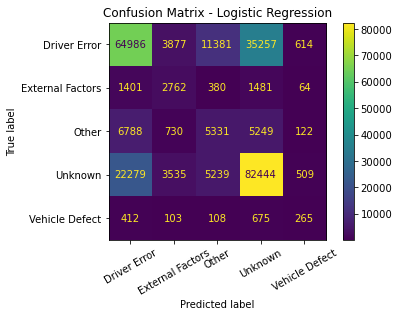

In [74]:
# Evaluate logistic regression model and store results
results = []
result_logreg = evaluate("Logistic Regression", logreg_pipe)
results.append(result_logreg)


Decision Tree
Accuracy: 0.6467
Macro F1 : 0.2946

Classification report:


c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

                  precision    recall  f1-score   support

    Driver Error       0.64      0.68      0.66    116115
External Factors       0.45      0.06      0.11      6088
           Other       0.00      0.00      0.00     18220
         Unknown       0.66      0.75      0.70    114006
  Vehicle Defect       0.00      0.00      0.00      1563

        accuracy                           0.65    255992
       macro avg       0.35      0.30      0.29    255992
    weighted avg       0.59      0.65      0.61    255992



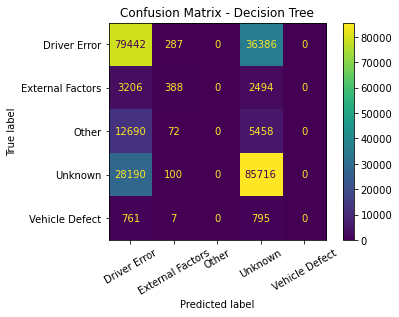

In [76]:
# Evaluate decision tree model and store results
result_tree = evaluate("Decision Tree", tree_pipe)
results.append(result_tree)

In [ ]:
# Evaluate random forest model and store results
result_rf = evaluate("Random Forest", rf_pipe)
results.append(result_rf)